#### Load the packages

In [1]:
!pip install -q opencv-python numpy dlib face_recognition tqdm pandas unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from IPython.display import display, Javascript, Image
from PIL import Image, ImageDraw
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import unidecode
import PIL
import io
import html
import time
import dlib
import os
import face_recognition as fr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from datetime import datetime
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This is for later but you need to update it

sender_email = "XXX"  # Replace with your email
sender_password = "XXX"  # Replace with your APP PASSWORD (see https://support.google.com/mail/answer/185833?hl=en to define an APP PASSWORD)

#### Load the faces you want to detect later on (this takes 5 minutes)

Basically, the load_known_faces is looping through every known faces to compute a unique 128-dimensional embedded vector for every student that is built thanks to the landmarks of the face detected on the picture. These vectors will serve to do the comparisons with new faces on a picture later on.

In [4]:
def load_known_faces(folder_path):
    known_face_encodings = []
    known_face_names = []
    landmarks = []

    for person_name in tqdm(os.listdir(folder_path), desc="Loading known faces"):
        person_folder_path = os.path.join(folder_path, person_name)

        if os.path.isdir(person_folder_path):
            # Assuming each person's folder contains only one image in .jpg format
            image_path = os.path.join(person_folder_path, os.listdir(person_folder_path)[0])

            # Load the image, compute face encoding and face's landmark
            person_image = fr.load_image_file(image_path)
            person_encoding = fr.face_encodings(person_image)[0]
            landmark = fr.face_landmarks(person_image)

            # Append the encoding, name and landmark to the lists
            known_face_encodings.append(person_encoding)
            known_face_names.append(person_name)
            landmarks.append(landmark)

    return known_face_encodings, known_face_names, landmarks

In [5]:
faces_folder_path = 'XXX' # Replace with the path to the folder containing the faces' images
image_files = os.listdir(faces_folder_path)

# Load known faces from the "Students" folder
known_face_encodings, known_face_names, landmarks = load_known_faces(faces_folder_path)

assert(len(known_face_names) == len(image_files))
print("All images have been processed")

Loading known faces: 100%|██████████| 38/38 [05:31<00:00,  8.71s/it]

All images have been processed


#### Plot some examples

The 128-dimensional embedding vector is [-0.16650885  0.03620809  0.02553942 -0.07304144 -0.13622572  0.03410155
 -0.01763096  0.00263347  0.15068507 -0.04866625  0.22679052  0.03588703
 -0.24095297 -0.06365756  0.03143913  0.13501886 -0.10079748 -0.07596932
 -0.13914976 -0.07805033  0.0006188   0.06675325  0.03443993  0.13176496
 -0.22517997 -0.23891851 -0.03902798 -0.172704    0.08439732 -0.20183747
 -0.03798922  0.00971431 -0.15256682 -0.09546602  0.05489219  0.10439511
 -0.12587312 -0.15589723  0.25445884  0.04954448 -0.16830465  0.01712824
  0.08773367  0.25610733  0.13577276 -0.01693514  0.06387746 -0.09445472
  0.19899443 -0.25471288  0.0928264   0.12466141  0.13825169  0.07082152
  0.13382404 -0.16527565  0.07311723  0.2104573  -0.21824807  0.12941517
 -0.00044606  0.01899651 -0.03657447  0.00818357  0.16669109  0.05423677
 -0.10080072 -0.12651436  0.17865284 -0.06584576 -0.04521745  0.20600745
 -0.13615733 -0.23571467 -0.20364308  0.10689612  0.3614082   0.15791084
 -0.1378987

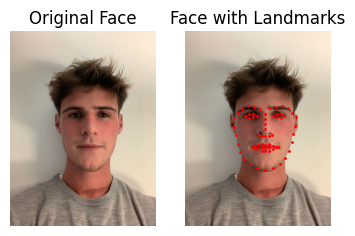

In [6]:
import os
import face_recognition as fr
import cv2
import matplotlib.pyplot as plt

def plot_face_with_landmarks_and_encoding(image_path):
    # Load the image
    image = fr.load_image_file(image_path)

    # Find face locations, landmarks, and encodings
    face_locations = fr.face_locations(image)
    face_landmarks = fr.face_landmarks(image)
    face_encodings = fr.face_encodings(image, face_locations)

    # Plot the original face
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Face')
    plt.axis('off')

    # Plot the face with landmarks
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    for landmarks in face_landmarks[0].values():
        for landmark in landmarks:
            plt.plot(landmark[0], landmark[1], 'ro', markersize=1)
    plt.title('Face with Landmarks')
    plt.axis('off')

    print(f"The 128-dimensional embedding vector is {face_encodings[0]}")

path = "XXX" # Replace with the path to the image of one of the faces
plot_face_with_landmarks_and_encoding(path)


#### Some Javascript functions to access the local camera of the machine. Use take_photo function to take a photo and video_frame to record a video.

In [7]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img


def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [8]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


  return filename

In [9]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.4)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

#### Take a picture

In [17]:
picture_name = "photo.jpg"

filename = take_photo(picture_name)
print('{} saved'.format(filename))

<IPython.core.display.Javascript object>

photo.jpg saved


#### Some toy use cases for detecting faces and landmarks

7 face(s) found  in this photograph.
A face is located at pixel location Top: 288, Left: 304, Bottom: 442, Right: 459


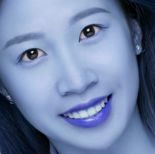

A face is located at pixel location Top: 737, Left: 1108, Bottom: 960, Right: 1331


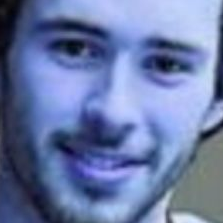

A face is located at pixel location Top: 222, Left: 1418, Bottom: 407, Right: 1604


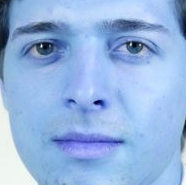

A face is located at pixel location Top: 696, Left: 572, Bottom: 882, Right: 758


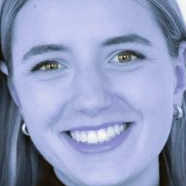

A face is located at pixel location Top: 663, Left: 142, Bottom: 885, Right: 365


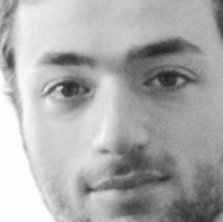

A face is located at pixel location Top: 340, Left: 812, Bottom: 469, Right: 941


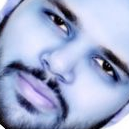

A face is located at pixel location Top: 655, Left: 1521, Bottom: 841, Right: 1707


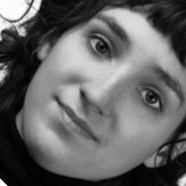

In [11]:
# Crop all the faces

image = fr.load_image_file("XXX") # Replace with the path to the image of a picture

# Find all the faces in the image using the default HOG-based model.
face_locations = fr.face_locations(image)

print("{} face(s) found  in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    face_image = image[top:bottom, left:right]
    cv2_imshow(face_image)

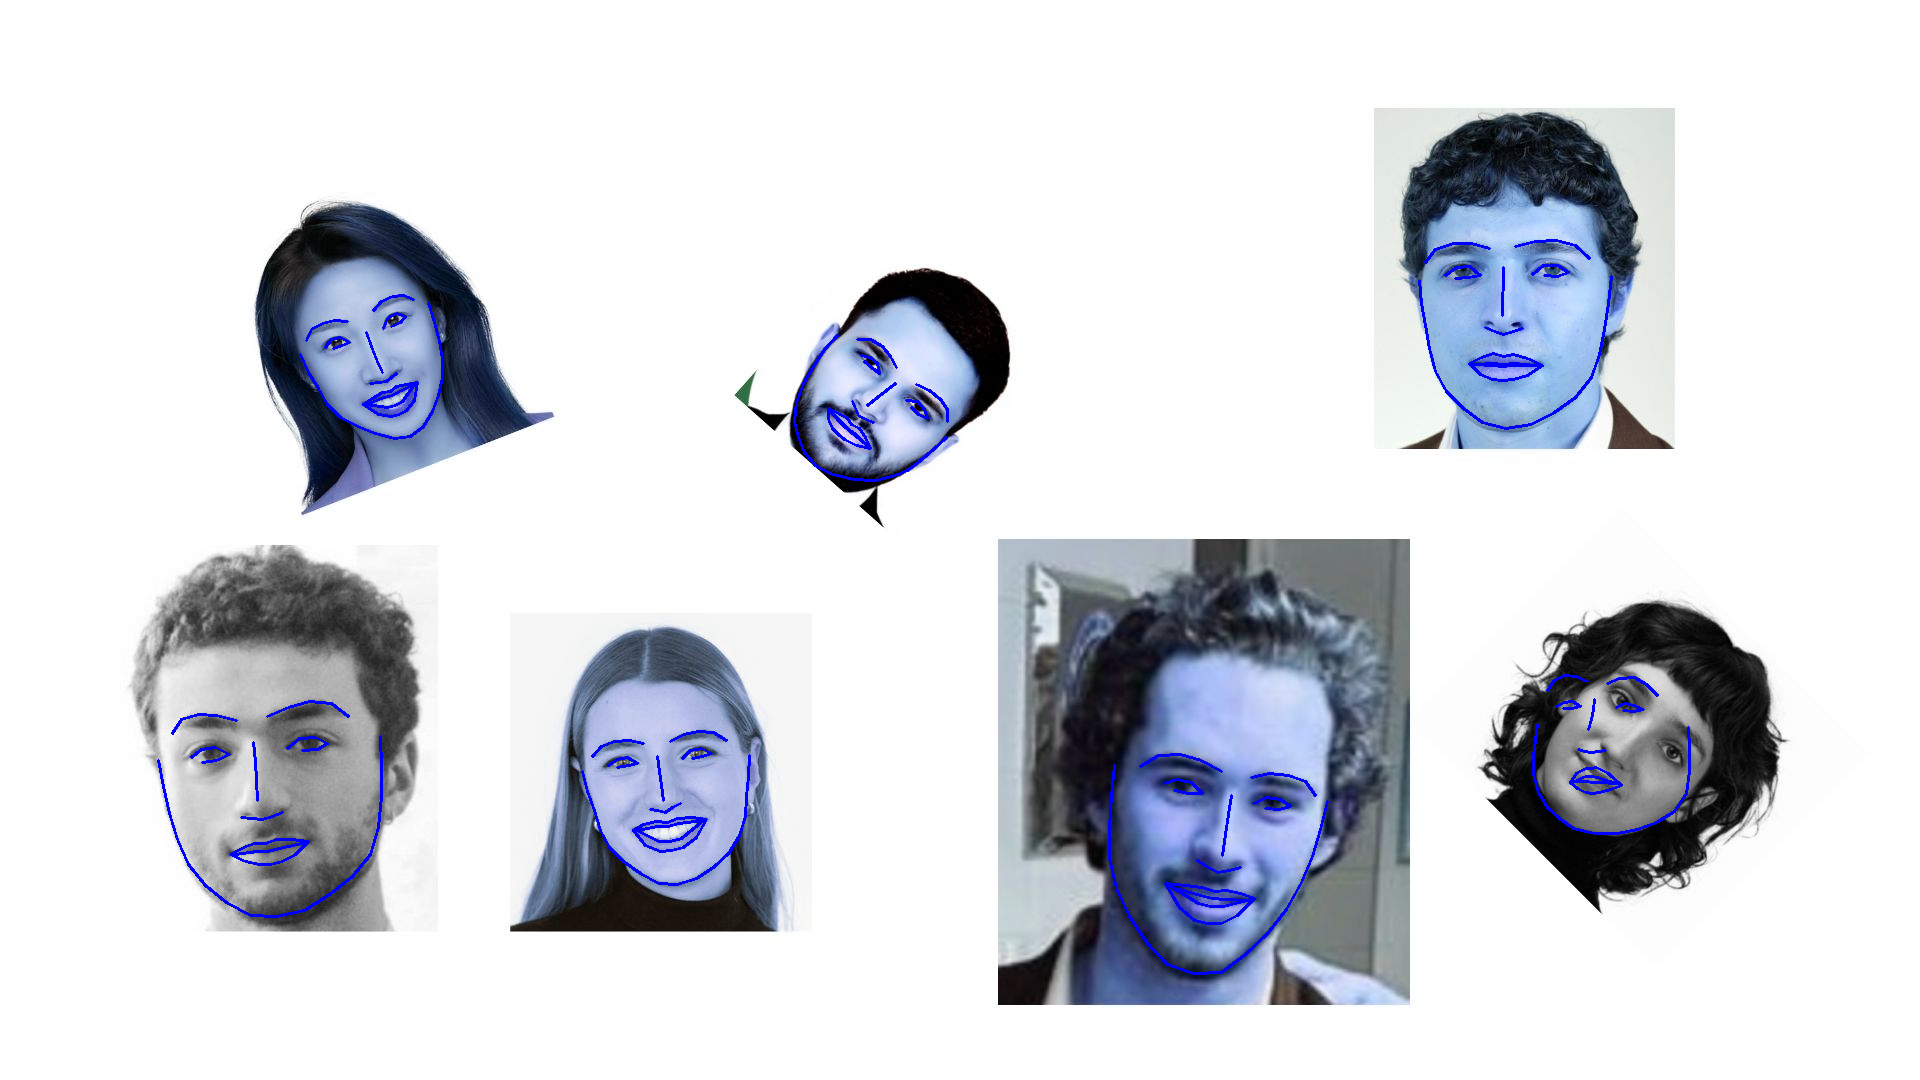

In [12]:
# Draw the landmarks detected on faces

face_landmarks_list = fr.face_landmarks(image)

for face_landmarks in face_landmarks_list:

    # Draw the facial feature
    for facial_feature in face_landmarks.keys():
        points = np.array(face_landmarks[facial_feature], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.polylines(image, [points], isClosed=False, color=(255, 0, 0), thickness=2)

# Show the picture
cv2_imshow(image)

#### Use case to send an email to the people present of the picture

In [2]:
emails_df = pd.read_excel('XXX') # Replace with the path to the Excel file containing the information


### Suppose that you have a column "Prénom" , "Nom" and "Email" in your Excel file

emails_df['Full Name'] = emails_df['Prénom'] + ' ' + emails_df['Nom']
emails_df

NameError: name 'pd' is not defined

In [ ]:
full_names_in_emails = [unidecode.unidecode(str(name).lower().strip()) for name in emails_df["Full Name"].tolist()]
known_face_names_lower = [unidecode.unidecode(name.lower().strip().replace('\t', ' ')) for name in known_face_names]

unmatched_names = [name for name in known_face_names_lower if name not in full_names_in_emails]

if not unmatched_names:
    print("Every name in known_face_names matches with the 'Full Name' column in emails.xlsx")
else:
    print("Names that don't have any email in the file")
    print(unmatched_names)

Names that don't have any email in the file
['heloise braun', 'mingjia chen', 'hari chandana chinni', 'riccardo garola', 'ayushi gupta', 'xiaochen - christian hu', 'olivier hubert', 'solene  leboucher', 'clelia misslin', 'vivien mollinari', 'nicolas perion-quemeneur', 'rahul sudesh sharma']


You should inspect these names and probably add their emails to the xls file

In [15]:
def send_email(name, receiver_email, subject, body, image):

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Add body to email
    message.attach(MIMEText(body, "plain"))

    img = MIMEImage(image, name=f'{name}.jpg')
    message.attach(img)

    # Connect to the SMTP server (e.g., Gmail)
    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, sender_password)

        # Send the email
        server.sendmail(sender_email, receiver_email, message.as_string())

#### Detect and recognize people on the picture thanks to the known_face_encodings previously defined. An email is sent to every person detected.

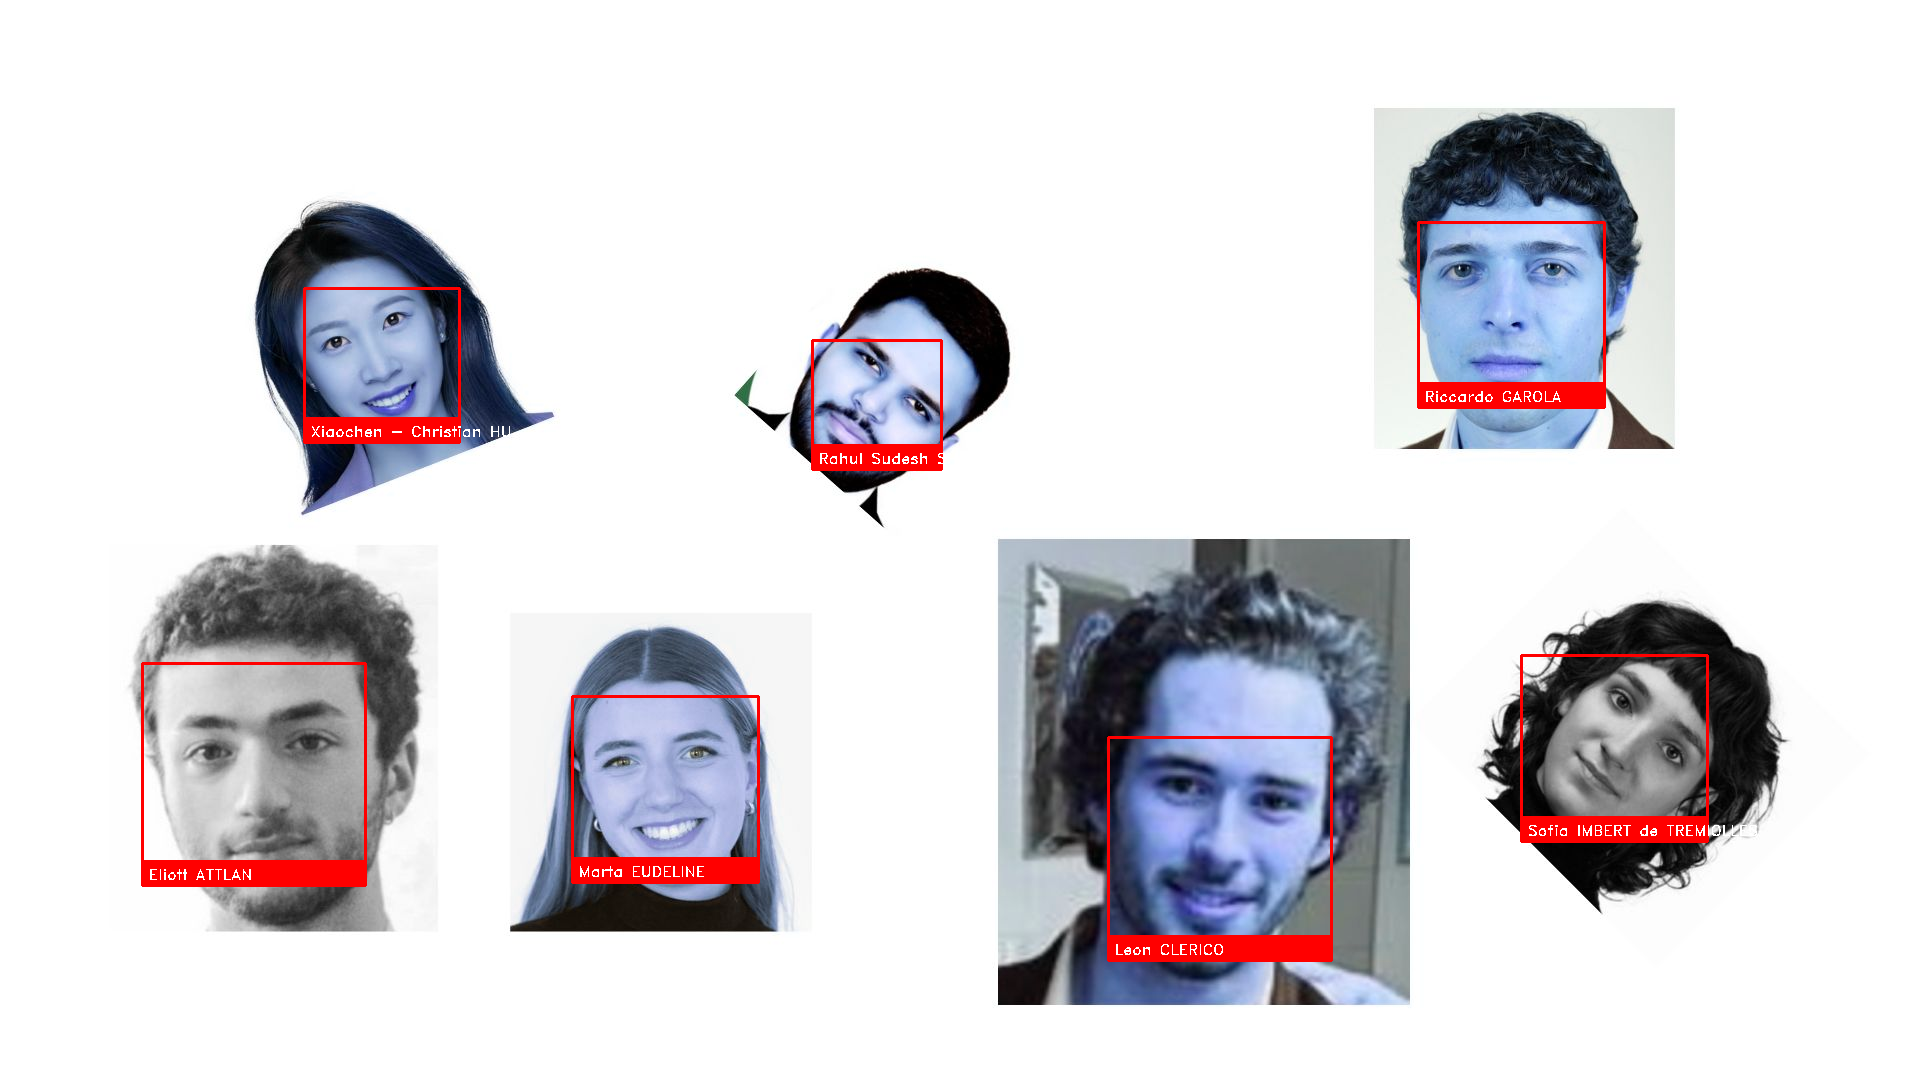

In [16]:
# Load an image with an unknown face
image = fr.load_image_file("XXX") # Replace with the path to the image of a picture

# Find all the faces and face encodings in the unknown image
face_locations = fr.face_locations(image)
face_encodings = fr.face_encodings(image, face_locations)


# Loop through each face found in the image
for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    # See if the face is a match for the known face(s)
    matches = fr.compare_faces(known_face_encodings, face_encoding)

    name = "Unknown"

    #If a match was found in known_face_encodings, just use the first one.
    if True in matches:
        first_match_index = matches.index(True)
        name = known_face_names[first_match_index]


        ###### DECOMMENT THIS PART TO SEND THE EMAIL TO THE PEOPLE IN THE PICTURE #######
        # matching_name_lower = unidecode.unidecode(name.lower().strip().replace('\t', ''))
        # matching_row = emails_df[unidecode(emails_df['Full Name'].str.lower().strip().replace('\t', '')) == matching_name_lower]

        # if not matching_row.empty:
        #     receiver_email = matching_row['Mail'].iloc[0]

        #     # Send a personalized email
        #     subject = f"" # Replace with the subject of the email
        #     body = f"" # Replace with the body of the email
        #     cropped_face = image[top:bottom, left:right]
        #     _, img_data = cv2.imencode('.jpg', cropped_face)
        #     img_data = img_data.tobytes()


        #     send_email(name, receiver_email, subject, body, img_data)


    # Draw a box around the face using the Pillow module
    cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 2)

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.rectangle(image, (left, bottom - 25), (right, bottom), (0, 0, 255), cv2.FILLED)
    cv2.putText(image, unidecode.unidecode(name), (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)


cv2_imshow(image)

#### Face detection on a video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

while True:

    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])

    if process_this_frame:

        small_frame = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)

        # Find all the faces and face encodings in the current frame of video
        face_locations = fr.face_locations(small_frame)
        face_encodings = fr.face_encodings(small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = fr.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = fr.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

    process_this_frame = not process_this_frame


    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)


    # Loop through each face in this frame of video
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):

        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Draw a box around the face
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 0, 255), 2)

        font_size = 0.5
        # Draw a label with a name below the face
        cv2.rectangle(bbox_array, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(bbox_array, name, (left + 6, bottom - 6), font, font_size, (255, 255, 255), 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>